# Cognitive Age Prediction with MEG

In [1]:
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from camcan.processing import SPoC
from camcan.utils import (plot_pred, plot_learning_curve,
                          plot_barchart, run_meg_ridge)

%matplotlib inline

/home/okozyn/anaconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
CV = 10
# store mae, std for the summary plot

## Read Data

In [3]:
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)
subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 643 subjects, each covariance is 9x306x306
data = mne.externals.h5io.read_hdf5('../../data/covs_allch_oas.h5')

print(f'Found {len(data)} subjects')
print(f'A covarince matrix shape is {data[0]["covs"].shape}')

Found 643 subjects
A covarince matrix shape is (9, 306, 306)


In [5]:
read sample data to prepare picks for epochs? Is it?
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname)
info = raw.info

## SPoC and Age Prediction

In [6]:
FREQ_BANDS = [(0.1, 1.5),  # low
              (1.5, 4.0),  # delta
              (4.0, 8.0),  # theta
              (8.0, 15.0),  # alpha
              (15.0, 26.0),  # beta_low
              (26.0, 35.0),  # beta_high
              (35.0, 50.0),  # gamma_low
              (50.0, 74.0),  # gamma_mid
              (76.0, 120.0)]  # gamma_high

Opening raw data file /home/okozyn/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
MAE: 9.22
MAE STD: 0.53


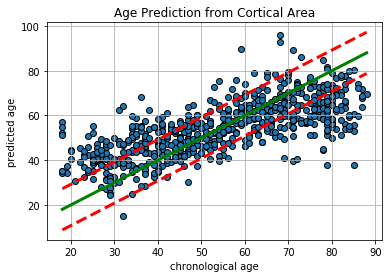

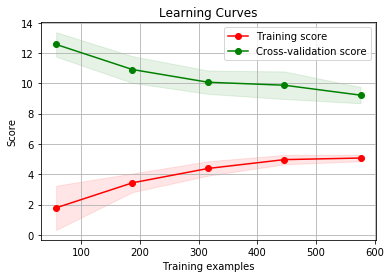

In [8]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, _ = \
    run_meg_ridge(data, subjects_data, alphas=np.logspace(-3, 5, 100), cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae_std['Cortical Surface Area'] = (mae, std)

plot_pred(y, y_pred, mae, title='Age Prediction from MEG with SPoC')
plot_learning_curve(train_sizes, train_scores, test_scores)

Results from the draft MAE : 8.878296175819491 (0.7210095297215949)

What to do next?

1. Stacking with MEG and MRI
2. Plots as with MRI
3. Run code for MRI to check whether everything is fine after the previous merge
4. Retreat project